# Предсказание оттока клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Одна из задач, которую хочет решить сеть — отток клиентов. «Культурист-датасаентист» считает, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

## Содержание<a name="Содержание"></a>

1. [Загрузка данных](#1.-Загрузка-данных)
2. [Исследовательский анализ данных](#2.-Исследовательский-анализ-данных)
	1. [Общая информация](#Общая-информация)
	2. [Баланс классов](#Баланс-классов)
	3. [Сравнение активных и ушедших клиентов](#Сравнение-активных-и-ушедших-клиентов)
	4. [Поиск коррелирующих признаков](#Поиск-коррелирующих-признаков)
3. [Обучение и анализ моделей прогнозирования оттока](#3.-Обучение-и-анализ-моделей-прогнозирования-оттока)
	1. [Подготовка признаков](#Подготовка-признаков)
	2. [Логистическая регрессия](#Логистическая-регрессия)
	3. [Случайный лес](#Случайный-лес)
	4. [Cравнение качества моделей](#Cравнение-качества-моделей)
4. [Кластеризация клиентов](#4.-Кластеризация-клиентов)
	1. [Графики распределения для признаков по кластерам](#Графики-распределения-для-признаков-по-кластерам)
	2. [Описания кластеров](#Описания-кластеров)
5. [Выводы и рекомендации по работе с клиентами](#5.-Выводы-и-рекомендации-по-работе-с-клиентами)
	1. [Портрет аудитории](#Портрет-аудитории)
	2. [От каких факторов зависит оттток](#От-каких-факторов-зависит-оттток)
	3. [Лучшая модель для предсказания оттока](#Лучшая-модель-для-предсказания-оттока)
	4. [Описания кластеров](#Описания-кластеров)
	5. [Рекомендации по работе с клиентами](#Рекомендации-по-работе-с-клиентами)

## 0. Импорт библиотек

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

In [2]:
sns.set_style('darkgrid')

In [3]:
RANDOM_SEED = 42

## 1. Загрузка данных<a name="1.-Загрузка-данных"></a>

Сохраним данные в переменную `gym` и посмотрим на пять случайный строк.

In [4]:
gym = pd.read_csv('gym_churn.csv')
gym.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3521,1,1,1,0,1,1,1,28,68.629218,1.0,5,3.197160,3.218274,0
3481,0,1,0,0,1,1,1,30,44.419101,1.0,0,1.692924,1.613738,0
445,1,1,0,0,1,1,1,30,43.915935,1.0,4,1.005050,0.948593,0
2245,0,0,0,0,1,1,0,25,134.766754,1.0,1,1.381370,1.302035,1
3307,0,1,0,1,1,1,1,33,3.214819,1.0,4,1.557956,1.470755,0


«Культурист-датасаентист» подготовил данные, которые содержат информацию за месяц до оттока и факт оттока на определенный месяц. Набор данных включает следующие поля:

- `Churn` — факт оттока в текущем месяце (целевой признак);


- Данные клиента за предыдущий до проверки факта оттока месяц:
    - `gender` — пол;
    - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
    - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - `Phone` — наличие контактного телефона;
    - `Age` — возраст;
    - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
    

- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    - `Group_visits` — факт посещения групповых занятий;
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

[К содержанию](#Содержание)

## 2. Исследовательский анализ данных<a name="2.-Исследовательский-анализ-данных"></a>

Перед началом анализа для удобства приведем названия столбцов к нижнему регистру.

In [5]:
gym.columns = gym.columns.str.lower()
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Общая информация<a name="Общая-информация"></a>

Посмотрим на общую информацию о датасете и числовое описание данных.

In [6]:
print('\033[1m' + 'Общие информация' + '\033[0m')
gym.info()

Общие информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000

In [7]:
print('\033[1m' + 'Числовое описание данных' + '\033[0m')
gym.describe()

Числовое описание данных


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Что удалось выяснить**
1. Нам повезло, и в данных нет пропусков.
2. У нас есть категориальные признаки, а именно: `gender`, `near_location`, `partner`, `promo_friends`, `group_visits`, `churn`. Они уже имеют числовое представление.
3. Не похоже, что в данных есть выбросы. Большие максимальные значения можно объяснить лояльными клиентами и спортсменами.
4. Масштаб признаков сильно различается. Поэтому перед обучением данные надо будет стандартизировать.
5. Размерности признаков можно понизить. Сделаем это прямо сейчас:

In [8]:
for col in gym.columns:
    gym[col] = pd.to_numeric(gym[col], downcast='unsigned')
    gym[col] = pd.to_numeric(gym[col], downcast='float')

gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   uint8  
 1   near_location                      4000 non-null   uint8  
 2   partner                            4000 non-null   uint8  
 3   promo_friends                      4000 non-null   uint8  
 4   phone                              4000 non-null   uint8  
 5   contract_period                    4000 non-null   uint8  
 6   group_visits                       4000 non-null   uint8  
 7   age                                4000 non-null   uint8  
 8   avg_additional_charges_total       4000 non-null   float32
 9   month_to_end_contract              4000 non-null   uint8  
 10  lifetime                           4000 non-null   uint8  
 11  avg_class_frequency_total          4000 non-null   float

Размер датафрейма уменьшился почти в пять раз!

Опишем нашу аудиторию:
1. Мужчин и женщин примерно поровну. Средний и одновременно медаинный возраст — 29 лет.
2. 85% клиентов живут или работают рядом с фитнес-центрами.
3. Почти половина посетителей работает в компаниях-партнерах.
4. По акции «приведи друга» пришел 31% клиентов.
5. Средняя длительность текущего действующего абонемента — почти 5 месяцев, «срок годности» — 4 месяца. 
6. Групповые занятия хотя бы раз посещали 41% клиентов.
7. Средняя частота посещений в неделю за все время с начала действия абонемента и за последний месяц одинаковые — 2 раза.
8. Средняя суммарная выручка от дополнительных услуг — 147 рублей. С доппродажами у нас не очень 🙁

### Баланс классов<a name="Баланс-классов"></a>

Исследуем баланс классов.

In [9]:
class_balance = pd.concat([gym['churn'].value_counts(),
                           gym['churn'].value_counts(normalize=True)],
                          axis='columns')
class_balance.columns = ['absolute', 'share_of_total']
class_balance

,absolute,share_of_total
0,2939,0.73475
1,1061,0.26525


Как видно, классы несбалансированы: 73,5% клиентов считаются активными и только 26,5% попали в отток.

Из-за того, что остающихся клиентов больше, модели будут больше продстраивать под их параметры. Но у нас обратная задача: мы хотим, чтобы модель хорошо понимала и предсказывала «отваливающихся» посетителей.

Чтобы исправить эту проблему, при обучении моделей будем делать поправку на дисбаланс классов. Для этого укажем в параметрах `class_weight='balanced'`. 

### Сравнение активных и ушедших клиентов<a name="Сравнение-активных-и-ушедших-клиентов"></a>

Посмотрим, как различаются портреты активных и ушедших клиентов.

churn,Активные,Ушедшие
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445709,115.082901
month_to_end_contract,5.283089,1.662582


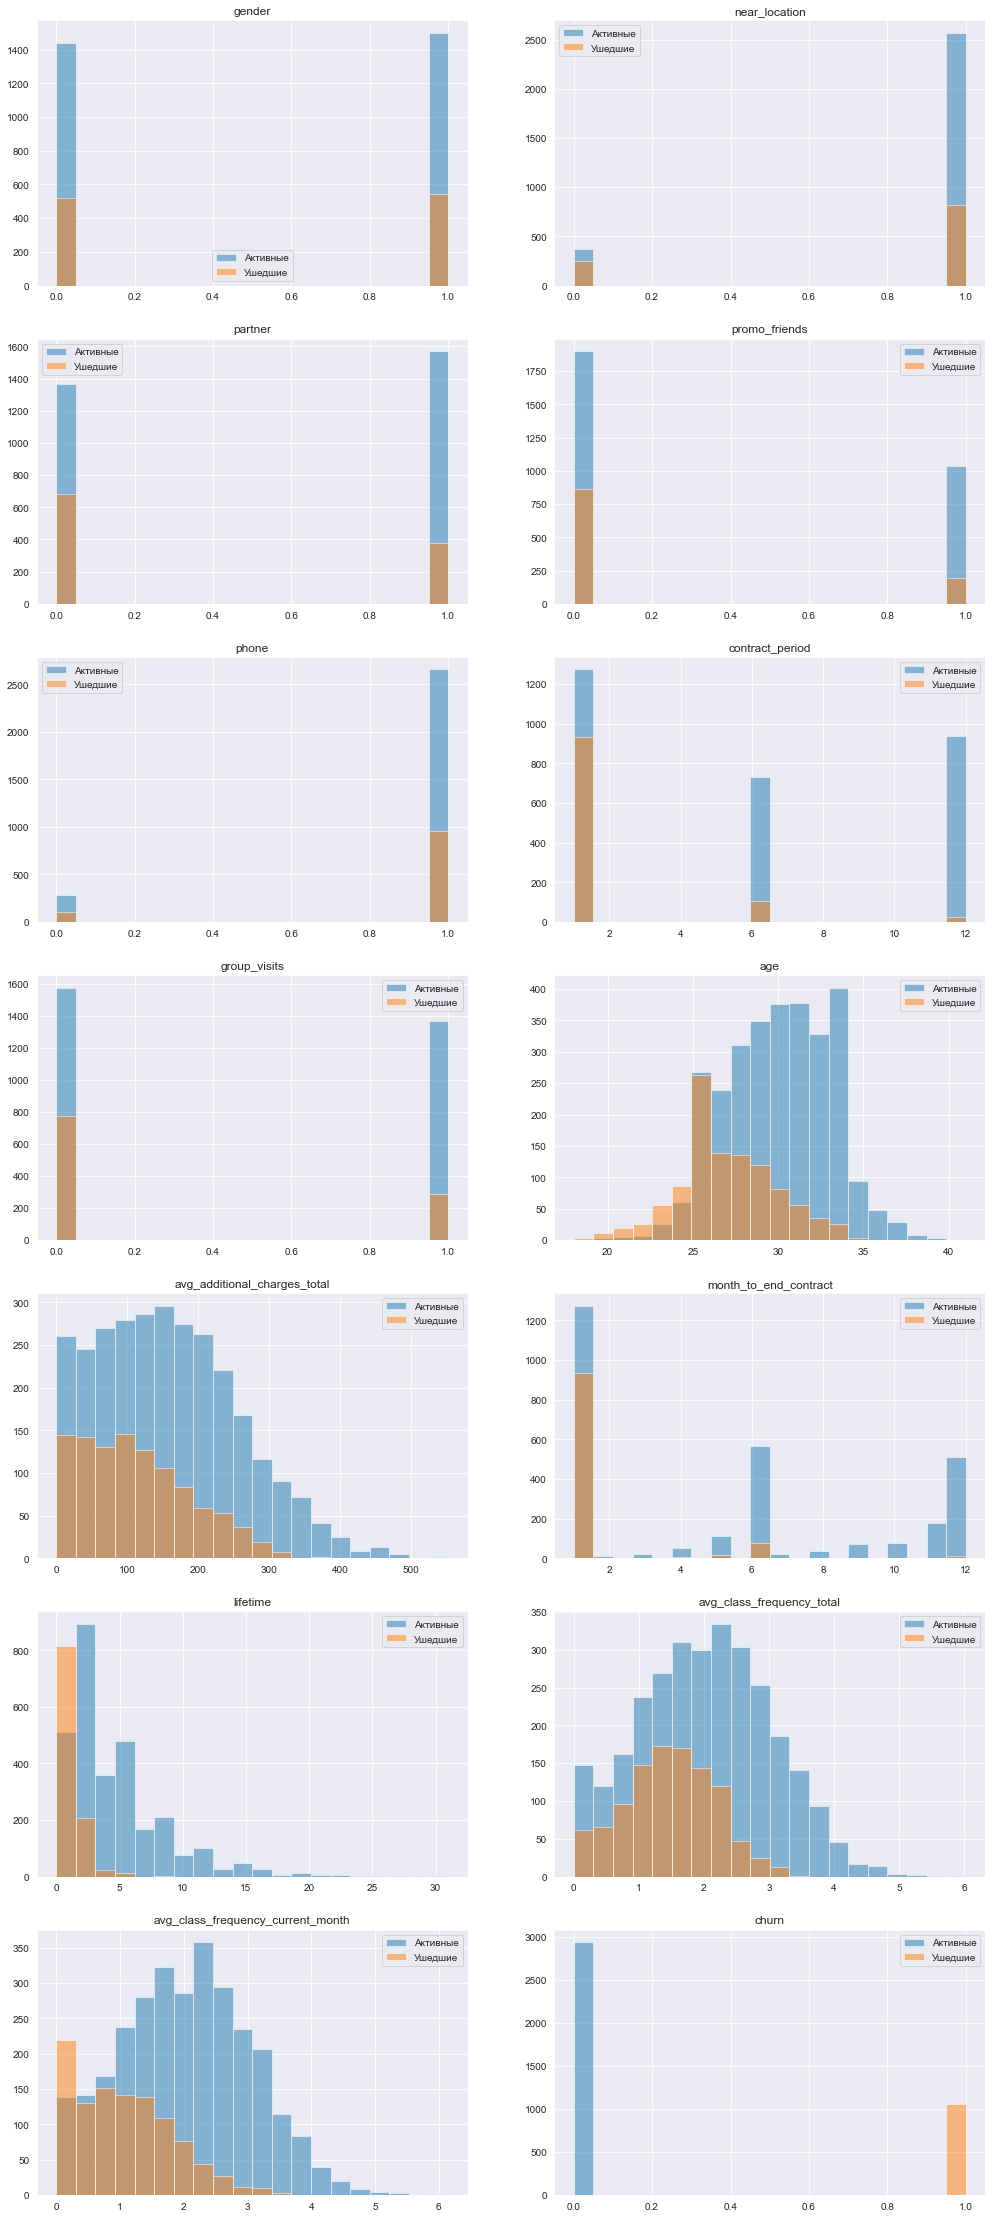

In [10]:
display(gym.groupby('churn').mean().T.rename(columns={0: "Активные", 1: "Ушедшие"}))

active = gym[gym['churn']==0]
churned = gym[gym['churn']==1]

fig, ax = plt.subplots(7, 2, figsize=(17, 40))
ax = ax.ravel()
for i in range(len(gym.columns)):
    col = gym.columns[i]
    ax[i].set_title(col)
    ax[i].hist(active[col], bins=20, range=(gym[col].min(), gym[col].max()), alpha=0.5, label='Активные')
    ax[i].hist(churned[col], bins=20, range=(gym[col].min(), gym[col].max()), alpha=0.5, label='Ушедшие')
    ax[i].legend()

Единственный одинаковый параметр в группах — гендерное соотношение клиентов. И там и там мужчин и женщин поровну.

Социальные параметры (участие в программе «приведи друга» и посещение групповых занятий) позитивно влияют на удержание клиентов. С друзьми тренироваться веселее! Также удерживающими факторами являются близость к дому или работе и скидки как сотрудникам компаний-партнеров. 

Текущие клиенты пользуются услугами фитнесс-центров активнее. Они дольше являются нашими посетителями, покупают более длительные абонементы, ходят на занятия почти в два раза чаще, чем ушедшие, и больше тратят на дополнительные услуги.

### Поиск коррелирующих признаков<a name="Поиск-коррелирующих-признаков"></a>

Проверим, как признаки коррелируют между собой.

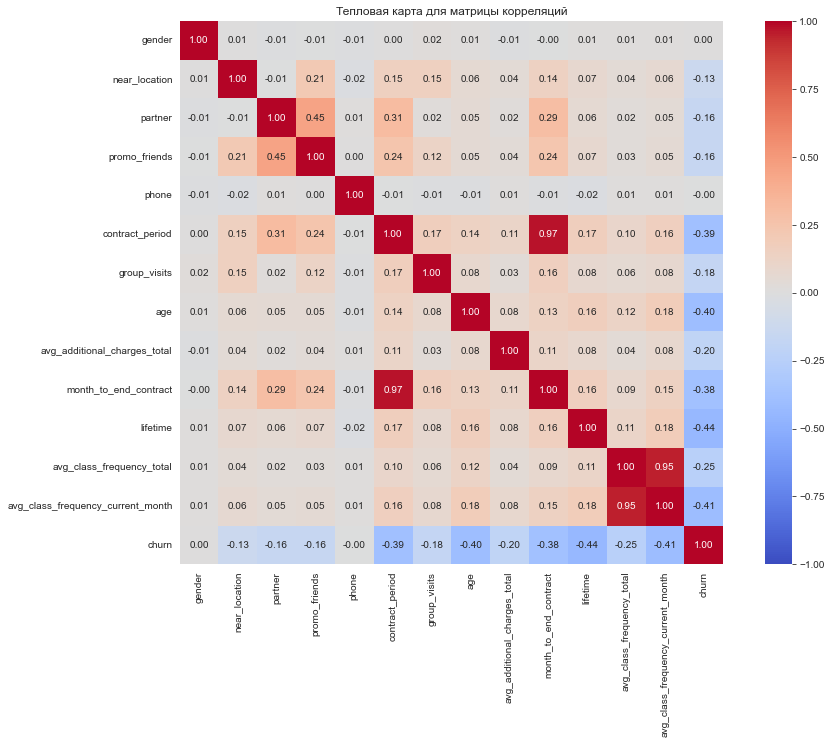

In [11]:
cm = gym.corr()

heat_map, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(cm, vmin=-1, vmax=1, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Тепловая карта для матрицы корреляций')

plt.show()

Целевой признак `churn` со всеми переменными связан обратно. 

Самые большие по модулю корреляции с:
- возрастом,
- «временем жизни»,
-средней частотой посещений в неделю за последний месяц,
- длительностью абонемента.

То есть чем старше клиент, чем дольше он с нами «живет» и планирует жить и чем чаще занимается, тем он более лояльный и тем меньше вероятность его оттока.

Есть две пары сильно коррелирующих признаков:
- **длительность абонемента и его остаток в месяцах**  
Это объясняется тем, что у нас больше половины проданных абонементов на месяц. Значит, и закончатся они через месяц, то есть остаток равен длительности.  

- **средняя частота посещений в неделю с начала действия абонемента и средняя частота посещений за последний месяц**  
Эта корреляция частично связана с певрой. Средняя частоста посещений в неделю за все время действия абонемента и так зависит от частоты за последний месяц. Но в нашем случае, когда половина абонементов на месяц, эти два периода равны. То есть два признака на самом деле измеряют одну и ту же величину.

Удалим по одному признаку из каждой коррелирующей пары для улучшения результата логистической регрессии.

In [12]:
gym = gym.drop(['avg_class_frequency_total', 'month_to_end_contract'], axis=1)
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_current_month', 'churn'],
      dtype='object')

[К содержанию](#Содержание)

## 3. Обучение и анализ моделей прогнозирования оттока<a name="3.-Обучение-и-анализ-моделей-прогнозирования-оттока"></a>

### Подготовка признаков<a name="Подготовка-признаков"></a>

Выделим из данных целевой признак и поделим их на обучающую и тестовую выборки. При разбиение укажем `stratify=y`, чтобы и в обучающей, и в валидационной выборках пропорции классов были одинаковыми.

In [13]:
X = gym.drop(['churn'], axis=1)
y = gym['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=RANDOM_SEED)

Мы будем исследовать два метода обучения модели: логистическую регрессию и случайный лес. Перед обучением стандартизируем данные, чтобы повысить качество регрессии.

In [14]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия<a name="Логистическая-регрессия"></a>

Наконец перейдем к обучению. Начнем с логистической регрессии.

In [15]:
log_reg_model = LogisticRegression(solver='liblinear',
                                   class_weight='balanced')
log_reg_model.fit(X_train_st, y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [16]:
log_reg_predictions = log_reg_model.predict(X_test_st)

### Случайный лес<a name="Случайный-лес"></a>

Теперь обучим случайный лес и получим его предсказания.

In [17]:
rand_frst_model = RandomForestClassifier(n_estimators=100,
                                         class_weight='balanced',
                                         random_state=RANDOM_SEED)
rand_frst_model.fit(X_train_st, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [18]:
rand_frst_predictions = rand_frst_model.predict(X_test_st)

### Cравнение качества моделей<a name="Cравнение-качества-моделей"></a>

Создадим функцию для вывода метрик accuracy, precision и recall, по которым мы будем сранивать модели. 

In [19]:
def show_classification_metrics(y_true, y_pred, title=''):
    print('\033[1m' + title + '\033[0m')
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred):.2f}')
    print(f'F1-score: {f1_score(y_true, y_pred):.2f}')

In [20]:
show_classification_metrics(y_test, log_reg_predictions ,
                            title='Метрики для логистической регрессии')

Метрики для логистической регрессии
Accuracy: 0.90
Precision: 0.76
Recall: 0.91
F1-score: 0.83


In [21]:
show_classification_metrics(y_test, rand_frst_predictions,
                            title='Метрики для случайного леса')

Метрики для случайного леса
Accuracy: 0.90
Precision: 0.83
Recall: 0.79
F1-score: 0.81


**Accuracy**

У обеих моделей `accuracy` одинаковая. Однако в нашей задаче эта метрика мало что говорит: у нас целевой класс в три раза меньше нецелевого. То есть даже если бы модель всем клиентам присваивала нулевой класс, ее `accuracy` была бы равна 75%.

**Precision**

У случайного леса `precision` больше, чем у логистической регрессии. То есть из определенных им в отток клиентов действительно уйдет большая доля, чем у регрессии.

Однако по этому показателю мы не можем судить, какую долю реального оттока находят модели.

**Recall**

Какую долю оттока нашли модели, показывает `recall`. И у логистической регрессии с этим гораздо лучше: она нашла 91% ушедших клиентов, а случайный лес — всего 79%.

**F1-мера**

Лучше найти как можно больше уходящих клиентов, но при этом ошибочно предложить скидку тем, кто и так бы остался? Или затраты на удержание слишком большие и лучше попробовать удержать меньшую долю клиентов, которая уйдет с большей вероятностью?

Без знания о том, во сколько нам обходится удержание потенциально уходящих клиентов, мы не можем сказать, что для нас важнее `recall` или `precision`. Поэтому воспользуемся агрегирующей эти показатели `F1-мерой`. У логистической регрессий она чуть больше, чем у случайного леса: 0,83 и 0,81 соответсвенно.

Таким образом, логистическая регрессия подходит для нашей задачи лучше.

[К содержанию](#Содержание)

## 4. Кластеризация клиентов<a name="4.-Кластеризация-клиентов"></a>

Перед кластеризацией еще раз стандартизируем данные. На этот раз будем обучать стандартизатор на всех объектах.

In [22]:
scaler = StandardScaler()
X_clust = scaler.fit_transform(X)

In [23]:
X_clust[:3]

array([[ 0.9797059 ,  0.42788076,  1.0268606 ,  1.497161  , -3.059852  ,
         0.28989014,  1.1940321 , -0.0565538 , -1.3775313 , -0.19332862,
        -1.678472  ],
       [-1.0207145 ,  0.42788076, -0.973842  , -0.66793084,  0.3268132 ,
         1.6088216 ,  1.1940321 ,  0.55732733, -0.3502133 ,  0.87368   ,
         0.1360137 ],
       [-1.0207145 ,  0.42788076,  1.0268606 , -0.66793084,  0.3268132 ,
        -0.8092194 , -0.8374985 , -0.36349437, -0.18159223, -0.4600808 ,
        -0.02901847]], dtype=float32)

Поделим объекты на кластеры с помощью метода k-средних. Заказчик попросил выделить пять кластеров.

In [24]:
km = KMeans(n_clusters=5, random_state=RANDOM_SEED)
kmeans_labels = km.fit_predict(X_clust)
gym['cluster_km'] = kmeans_labels

gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202934,7,1.910244,0,1
2,0,1,1,0,1,1,0,28,129.448486,2,1.736502,0,4
3,0,1,1,1,1,12,1,33,62.669865,2,3.357214,0,1
4,1,1,1,1,1,1,0,26,198.362259,3,1.120078,0,4


Посмотрим на средние значения признаков для кластеров.

In [25]:
clusters_stat = gym.groupby(['cluster_km']).mean().sort_values(by='churn', ascending=False)
clusters_stat

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.498214,0.000000,0.487500,0.078571,1.0,3.016071,0.233929,28.698214,137.520966,3.019643,1.601681,0.401786
4,0.484354,1.000000,0.934694,0.541497,1.0,2.715646,0.268027,28.278912,127.237839,2.674830,1.404365,0.372789
2,0.528288,1.000000,0.000000,0.055107,1.0,2.736958,0.405584,29.032329,142.722839,3.288024,1.705114,0.332109
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208176,3.940415,1.723967,0.266839
1,0.506263,0.993737,0.840292,0.625261,1.0,9.886221,0.630480,30.332985,174.669327,5.475992,2.247335,0.007307


Про зависимость оттока от дискретных величин сложно что-то сказать.

Зато видно, что почти во всех случаях непрерывные переменные выстроились по возрастанию. То есть еще раз подтвердилась обратная зависимость оттока от этих признаков. Чем больше клиент пользуется услугами фитнес-центра и чем чаще занимается, тем меньше вероятность его оттока.

### Графики распределения для признаков по кластерам<a name="Графики-распределения-для-признаков-по-кластерам"></a>

Чтобы лучше понять особенности кластеров, построим распределения признаков.

Для непрерывных признаков будем строить диаграммы размаха. Столбцы гистограмм сложно разобрать при большом количестве кластеров, и нам хватит информации от боксплотов. Для дискретных величин построим столбчатые диаграммы.

Сначала построим все графики, а затем выведем — так их будем удобнее анализировать.

In [26]:
graphs_order = clusters_stat.index

disc_features = ['gender', 'near_location', 'partner',
                 'promo_friends', 'phone', 'contract_period',
                 'group_visits', 'churn']

cont_features = ['age', 'avg_additional_charges_total',
                 'lifetime', 'avg_class_frequency_current_month']

In [27]:
disc_graphs, ax = plt.subplots(4, 2, figsize=(15, 30),
                               gridspec_kw={'hspace': 0.25, 'wspace': 0.2})
disc_graphs.suptitle('Распределения дискретных величин для кластеров',
                     y=0.913, fontsize=18)    
ax = ax.ravel()

for i, col in enumerate(disc_features):
    sns.countplot(data=gym, x='cluster_km',
                  hue=col, ax=ax[i], order=graphs_order)
    ax[i].set_title('Распределение признака \n'+ col)
    ax[i].grid()
    
plt.close()    

In [28]:
cont_graphs, ax = plt.subplots(2, 2, figsize=(15, 15),
                               gridspec_kw={'hspace': 0.25, 'wspace': 0.15})
cont_graphs.suptitle('Распределения непрерывных величин для кластеров',
                     y=0.94, fontsize=18)    
ax = ax.ravel()

for i, col in enumerate(cont_features):
    sns.boxplot(data=gym, x=col, y='cluster_km',
                orient='h', ax=ax[i], order=graphs_order)
    ax[i].set_title('Распределение признака \n'+ col)
    ax[i].grid()
    
plt.close()

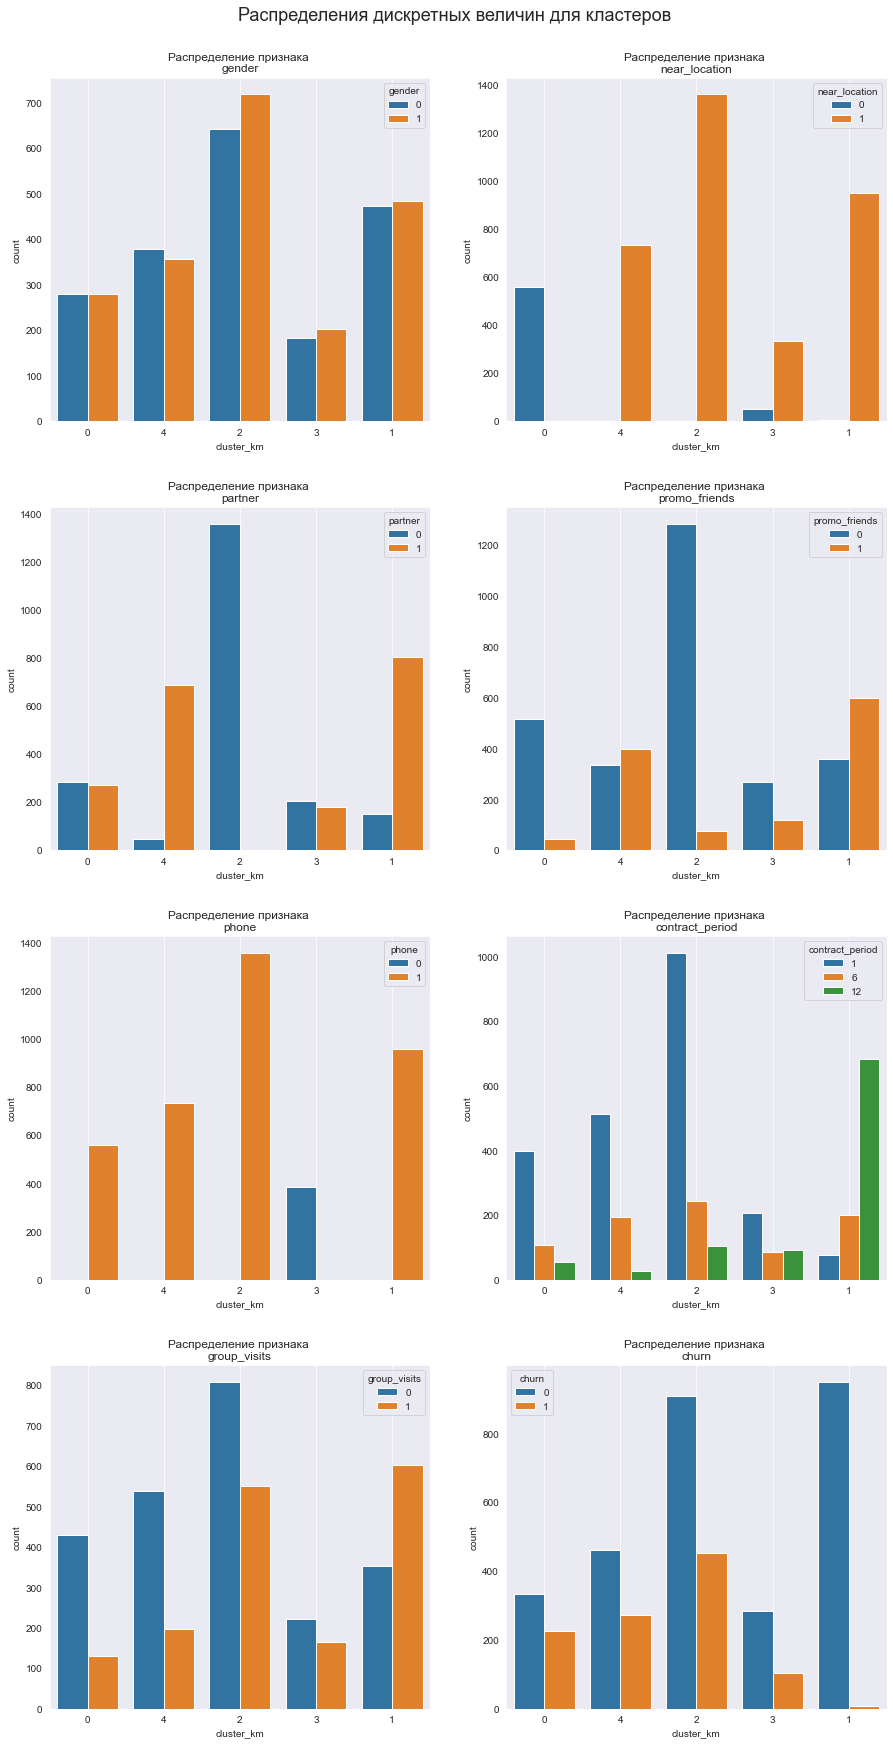

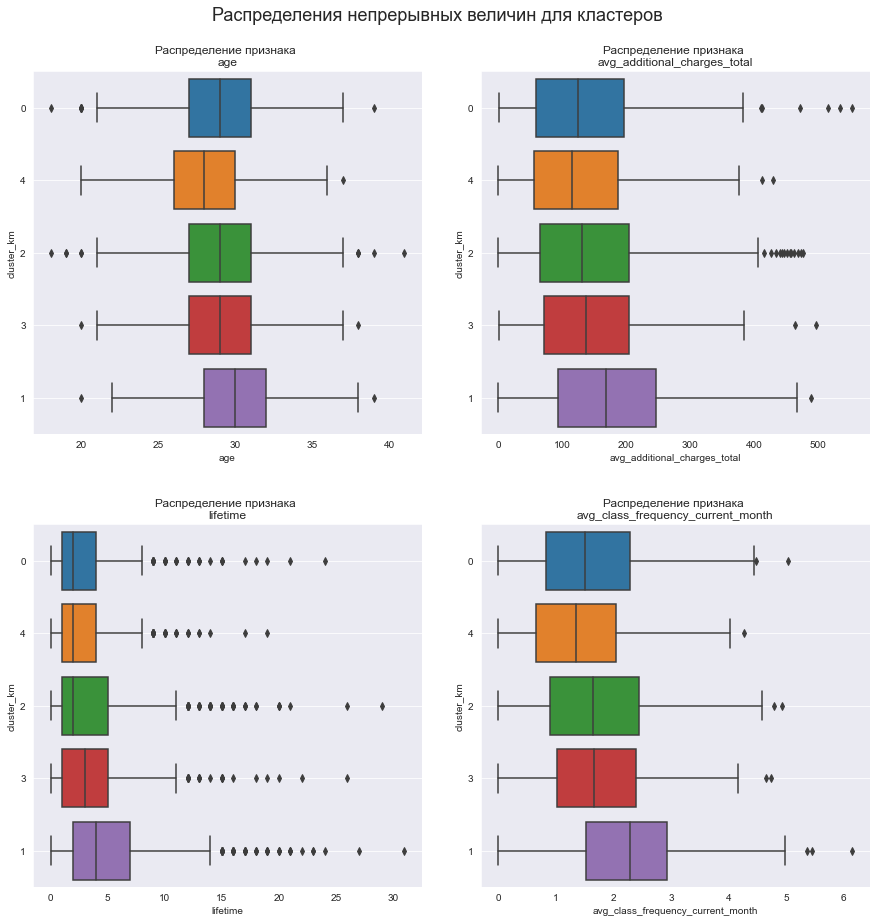

In [29]:
display(disc_graphs)
cont_graphs

Благодаря визуализации стало удобнее оценивать дискретные признаки.

### Описания кластеров<a name="Описания-кластеров"></a>

#### Нулевой кластер

1. Почти все пользователи, которые не живут и не работают рядом с фитнес-центрами, попали в нулевой кластер. Доля оттока в нем максимальная и равна 40%.
2. Также особенностью этого кластера можно назвать его слабую социальную привязанность к фитнес-центрам. Меньше четверти клиентов из него ходили на групповые занятия — это самый низкий показатель среди всех кластеров.
3. А еще в этом кластере мало клиентов пишли по приглашению друзей — всего 7%.

#### Четвертый кластер

1. Второй по доле оттока кластер — с номером 4. Доля оттока — 37%.
2. Клиентов из этого кластера хорошо характеризуют непрерывные переменные. Посетители из четвертого кластера самые молодые по возрасту и по времени жизни с нами, а еще они реже всех занимались в последнем месяце.
3. Также у них самая маленькая средняя длительность абонемента. 

#### Второй кластер

1. Кластер со вторым номером самый крупный: в нем больше 1300 клиентов, то есть больше четверти всей выборки.
2. К сожалению, доля оттока в нем тоже довольно большая — 33%.
3. Особенности кластера: отсутствие клиентов из компаний-партнеров и малое количество пришедших по программе «приведи друга».

#### Третий кластер

1. Кластер под номером 3 самый маленький: в него попали меньше 10% пользователей.
2. Что интересно, все клиенты в нем оставили телефонные номера.
3. Также по сравнению с предыдущими кластерами у него довольно высокая средняя длительность абонемента — 5 месяцев. На диаграмме видно, что абонементов на 6 и 12 месяц в нем продано почти поровну, а вместе они составляют почти половину от всех проданных кластеру.

#### Первый кластер

1. Первый кластер самый лояльный: доля оттока в нем меньше процента.
2. 84% клиентов в нем работают в компаних-партнерах, 63% пришли по приглашению друзей и столько же ходили на групповые занятия.
3. Самый популярный абонемент в кластере — на год, его выбрали больше 70% клиентов. Из-за это средняя длительность абонемента максимальная среди всех кластеров — 10 месяц.
4. Среднее время жизни клиента — полгода.

[К содержанию](#Содержание)

## 5. Выводы и рекомендации по работе с клиентами<a name="5.-Выводы-и-рекомендации-по-работе-с-клиентами"></a>

### Портрет аудитории<a name="Портрет-аудитории"></a>

В ходе исследования мы составили портрет нашей аудитории:

1. Мужчин и женщин примерно поровну. Средний и одновременно медианный возраст — 29 лет.
2. 85% клиентов живут или работают рядом с фитнес-центрами.
3. Почти половина посетителей работает в компаниях-партнерах.
4. По акции «приведи друга» пришел 31% клиентов.
5. Средняя длительность текущего действующего абонемента — почти 5 месяцев, «срок годности» — 4 месяца. 
6. Групповые занятия хотя бы раз посещали 41% клиентов.
7. Средняя частота посещений в неделю за все время с начала действия абонемента и за последний месяц одинаковые — 2 раза.
8. Средняя суммарная выручка от дополнительных услуг — 147 рублей.

### От каких факторов зависит оттток<a name="От-каких-факторов-зависит-оттток"></a>

Также мы выяснили, что оттток со всеми переменными связан обратно.

Самые большие по модулю корреляции с:
- возрастом,
- «временем жизни»,
-средней частотой посещений в неделю за последний месяц,
- длительностью абонемента.

То есть чем старше клиент, чем дольше он с нами «живет» и планирует жить и чем чаще занимается, тем он более лояльный и тем меньше вероятность его оттока.

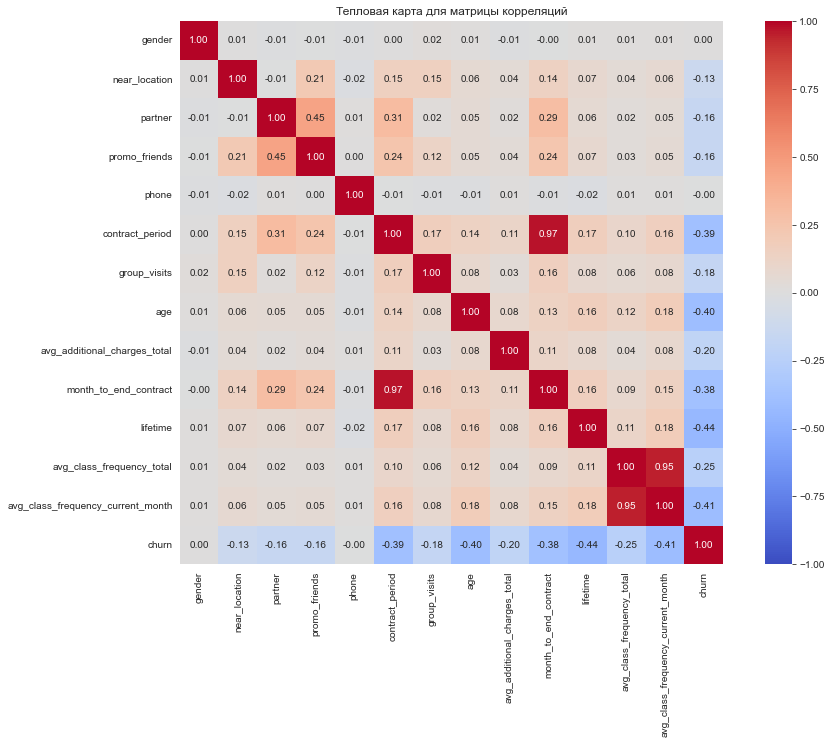

In [30]:
heat_map

### Лучшая модель для предсказания оттока<a name="Лучшая-модель-для-предсказания-оттока"></a>

Без знания о том, во сколько нам обходится удержание потенциально уходящих клиентов, мы не можем сказать, что для нас важнее `recall` или `precision`. `accuracy` не подходит для нашей задачи, так как классы несбалансированы.

Поэтому для определения лучшей модели мы выбрали агрегирующую `recall` и `precision` F1-мерe. У логистической регрессий она чуть больше, чем у случайного леса: 0,83 и 0,81 соответсвенно.

Таким образом, логистическая регрессия подходит для нашей задачи лучше.

In [31]:
show_classification_metrics(y_test, rand_frst_predictions, title='Метрики для случайного леса')

Метрики для случайного леса
Accuracy: 0.90
Precision: 0.83
Recall: 0.79
F1-score: 0.81


In [32]:
show_classification_metrics(y_test, log_reg_predictions , title='Метрики для логистической регрессии')

Метрики для логистической регрессии
Accuracy: 0.90
Precision: 0.76
Recall: 0.91
F1-score: 0.83


В конце мы разделили пользователей на пять кластеров и описали каждый. В этом нам помогли графики распределений признаков.

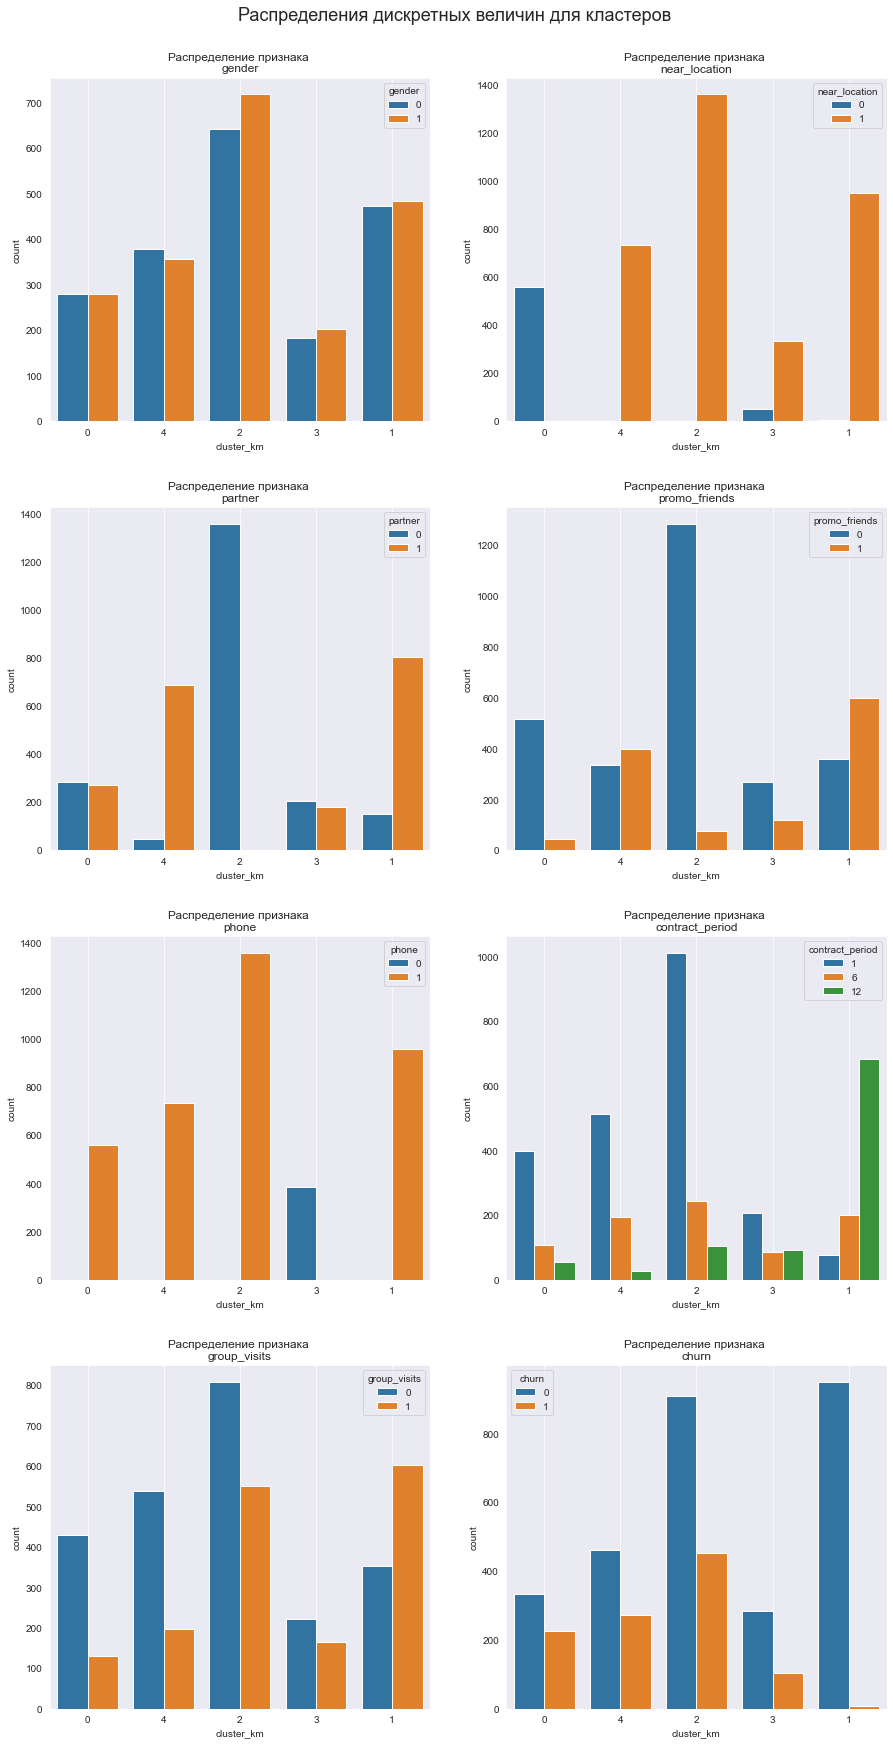

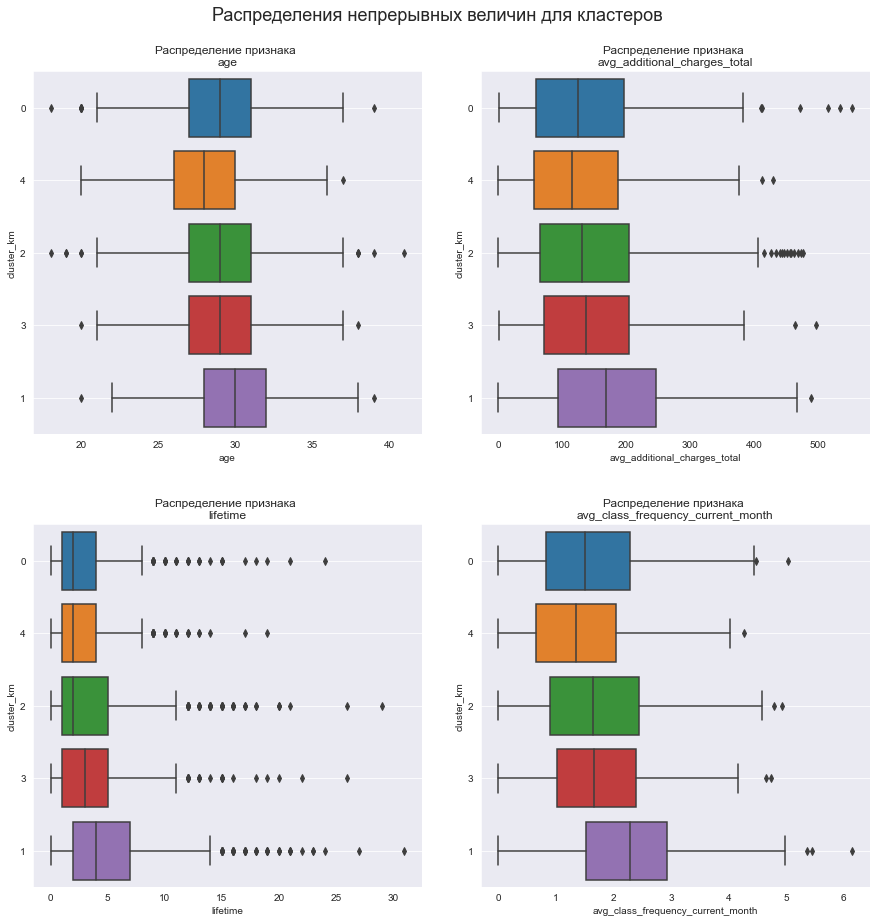

In [33]:
display(disc_graphs)
cont_graphs

### Описания кластеров<a name="Описания-кластеров"></a>

#### Нулевой кластер

1. Почти все пользователи, которые не живут и не работают рядом с фитнес-центрами, попали в нулевой кластер. Доля оттока в нем максимальная и равна 40%.
2. Также особенностью этого кластера можно назвать его слабую социальную привязанность к фитнес-центрам. Меньше четверти клиентов из него ходили на групповые занятия — это самый низкий показатель среди всех кластеров.
3. А еще в этом кластере мало клиентов пишли по приглашению друзей — всего 7%.

#### Четвертый кластер

1. Второй по доле оттока кластер — с номером 4. Доля оттока — 37%.
2. Клиентов из этого кластера хорошо характеризуют непрерывные переменные. Посетители из четвертого кластера самые молодые по возрасту и по времени жизни с нами, а еще они реже всех занимались в последнем месяце.
3. Также у них самая маленькая средняя длительность абонемента. 

#### Второй кластер

1. Кластер со вторым номером самый крупный: в нем больше 1300 клиентов, то есть больше четверти всей выборки.
2. К сожалению, доля оттока в нем тоже довольно большая — 33%.
3. Особенности кластера: отсутствие клиентов из компаний-партнеров и малое количество пришедших по программе «приведи друга».

#### Третий кластер

1. Кластер под номером 3 самый маленький: в него попали меньше 10% пользователей.
2. Что интересно, все клиенты в нем оставили телефонные номера.
3. Также по сравнению с предыдущими кластерами у него довольно высокая средняя длительность абонемента — 5 месяцев. На диаграмме видно, что абонементов на 6 и 12 месяц в нем продано почти поровну, а вместе они составляют почти половину от всех проданных кластеру.

#### Первый кластер

1. Первый кластер самый лояльный: доля оттока в нем меньше процента.
2. 84% клиентов в нем работают в компаних-партнерах, 63% пришли по приглашению друзей и столько же ходили на групповые занятия.
3. Самый популярный абонемент в кластере — на год, его выбрали больше 70% клиентов. Из-за это средняя длительность абонемента максимальная среди всех кластеров — 10 месяц.
4. Среднее время жизни клиента — полгода.

### Рекомендации по работе с клиентами<a name="Рекомендации-по-работе-с-клиентами"></a>

Чтобы лучше удерживать клиентов, стоит обратить внимание на параметры, которые обратно коррелируют с оттоком и на которые мы можем повлиять. А именно:

- Надо развивать групповые тренировки, так как их посещение повышает лояльность клиентов. Можно добавить новые виды спорта или сделать более удобное расписание. Это также может повысить частоту посещений фитнес-центров, что позитивно скажется на оттоке.
- Стоит развивать сотрудничество с компаниями-партнерами. Возможно, их заинтересуют выездные тренировки или организация спортивной активности прямо в офисе.
- Полезно улучшать программу «приведи друга» и стимулировать клиентов приводить новых друзей. Например, за каждого следующего друга можно давать больше бонусов, чем за предыдущего.

[К содержанию](#Содержание)